In [24]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

import h5py as h5
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [25]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [26]:
def load_galaxy(sim, sd=None, idx=320):
    if sim=='iso':
        key = 'lvl4-Ngb64'
        output_dir = basepath + 'runs/MW7iso/'+ key + '/output'
    elif sd is not None:
        key = 'lvl4-sd'+str(sd)
        output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    else:
        key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
        output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    return galaxy.Galaxy(output_dir, idx, orient=True)

In [27]:
def extract_sim_data(gal, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        mask = np.full_like(in_SN, True)
    else:
        mask = in_SN
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(mask, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[mask]
    out['logMgFe'] = logMgFe[mask]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[mask]
    out['BirthMass'] = sn.part4.GFM_InitialMass[mask]
    out['in_SN'] = in_SN
    
    return out

In [28]:
sim = ('142', '116', '04')
gal = load_galaxy(sim)
simdat = extract_sim_data(gal, no_SN=True)
centering = np.load('../bim_metric/centering/sim_'+str(sim[0])+'_'+str(sim[1])+'_'+str(sim[2])+'.npy',
                    allow_pickle=True).item()

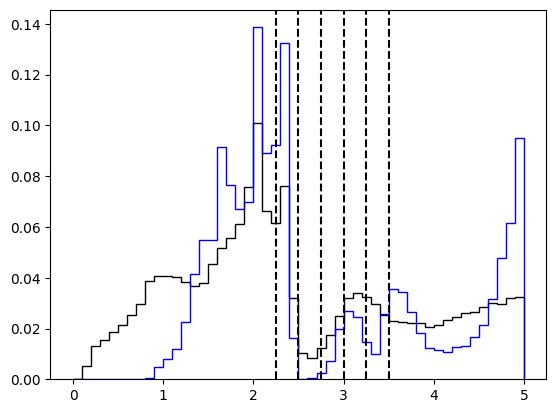

In [29]:
tform = simdat['GFM_StellarFormationTime']
bmass = simdat['BirthMass']
tbins = np.arange(0, 5+0.1, 0.1)

plt.hist(tform, weights=bmass, bins=tbins, histtype='step', color='k')

logFeH0 = 0
dlogFeH = 0.05
key = np.logical_and(simdat['logFeH'] > logFeH0 - dlogFeH/2., simdat['logFeH'] < logFeH0 + dlogFeH/2.)
plt.hist(tform[key], weights=bmass[key]/dlogFeH, bins=tbins, histtype='step', color='b')

plt.axvline(0.025*90, c='k', ls='dashed')
plt.axvline(0.025*100, c='k', ls='dashed')
plt.axvline(0.025*110, c='k', ls='dashed')
plt.axvline(0.025*120, c='k', ls='dashed')
plt.axvline(0.025*130, c='k', ls='dashed')
plt.axvline(0.025*140, c='k', ls='dashed')

In [30]:
idx_list = [90, 100, 110, 120, 130, 140, 0]
gal_list = []
for idx in tqdm(idx_list, leave=True, position=0):
    gal = load_galaxy(sim, idx=idx)
    gal_list.append(gal)

100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


In [31]:
Msat = np.sum(gal_list[0].sn.part0.mass * gal_list[0].sn.part0.PassiveScalars[:,0])
Msat += np.sum(gal_list[0].sn.part4.mass * gal_list[0].sn.part4.PassiveScalars[:,0])

Mcen = np.sum(gal_list[0].sn.part0.mass * gal_list[0].sn.part0.PassiveScalars[:,2])
Mcen += np.sum(gal_list[0].sn.part4.mass * gal_list[0].sn.part4.PassiveScalars[:,2])

print(Msat, Mcen)

8.025771 0.9520308


In [32]:
gal_list[6].sn.part0.PassiveScalars

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
def get_sfr_surfdens(gal, com, rmin=0.01, rmax=50, rfac=1.5, logFeH0=0, dlogFeH=0.05):

    r0 = np.linalg.norm(gal.sn.part0.pos - com, axis=1)
    sfr0 = gal.sn.part0.sfr.value
    globsfr = np.sum(sfr0)
    
    FeH = gal.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)
    key_Fe = np.logical_and(logFeH > logFeH0-dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)

    rave = []
    rhosfr = []
    rhosfr_Fe = []
    while rmin < rmax:
        key = np.logical_and(r0 > rmin, r0 < rmin*rfac)
        rave.append(np.mean(r0[key]))
    
        totsfr = np.sum(sfr0[key])
        # vol = (4*np.pi/3.) * ((rmin*rfac)**3 - rmin**3)
        vol = 1
        rhosfr.append(totsfr/vol)
        
        key = np.logical_and(key, key_Fe)
        totsfr_Fe = np.sum(sfr0[key])
        rhosfr_Fe.append(totsfr_Fe/vol)
    
        rmin *= rfac

    rave = np.array(rave)
    rhosfr = np.array(rhosfr)
    rhosfr_Fe = np.array(rhosfr_Fe)
    
    return rave, rhosfr, rhosfr_Fe, globsfr

/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[(0.0, 10.0), (0.0, 5.0)]

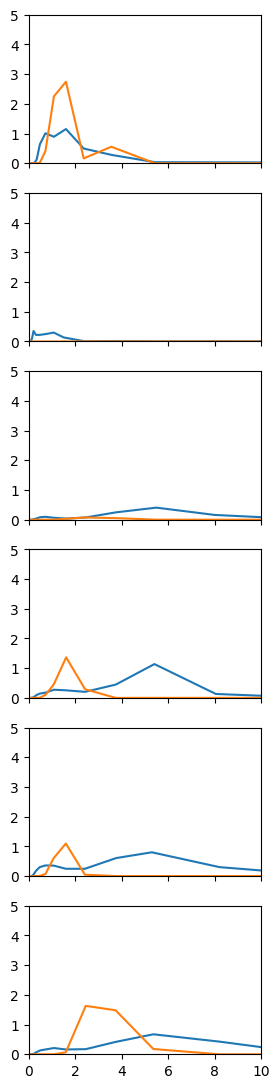

In [34]:
fig, axs = plt.subplots(6, 1, figsize=(3, 4.5*3), sharex=True, sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    idx = idx_list[i]
    gal = gal_list[i]
    com = centering['com0'][idx]
    
    rave, rhosfr, rhosfr_Fe, globsfr = get_sfr_surfdens(gal, com)

    ax.plot(rave, rhosfr)
    ax.plot(rave, rhosfr_Fe/0.05)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    
    # ax.text(8, 15, str(round(globsfr, 2)))

ax.set(xlim=(0, 10), ylim=(0, 5))

In [35]:
from scipy.stats import binned_statistic

In [36]:
def get_sfr_byFe(gal):
    sfr0 = gal.sn.part0.sfr.value
    globsfr = np.sum(sfr0)
    
    FeH = gal.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    FeHbins = np.linspace(-2, 1, 60)

    avelogFeH, _, _ = binned_statistic(logFeH, logFeH, bins=FeHbins)
    sfr_inbin, _, _ = binned_statistic(logFeH, sfr0, statistic='sum', bins=FeHbins)
    sfr_inbin /= FeHbins[1]-FeHbins[0]
    
    return avelogFeH, sfr_inbin, globsfr

[(-1.0, 1.0)]

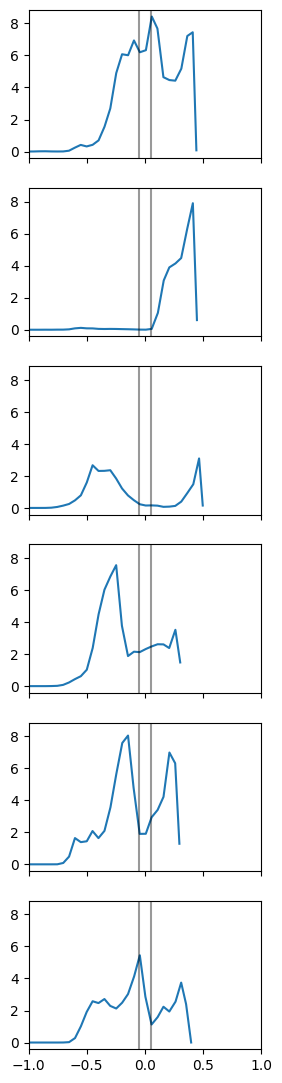

In [37]:
fig, axs = plt.subplots(6, 1, figsize=(3, 4.5*3), sharex=True, sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    idx = idx_list[i]
    gal = gal_list[i]
    
    avelogFeH, sfr_inbin, globsfr = get_sfr_byFe(gal)

    ax.plot(avelogFeH, sfr_inbin)
    ax.axvline(-0.05, c='k', alpha=0.4)
    ax.axvline(0.05, c='k', alpha=0.4)

# ax.set(xlim=(0, 10), ylim=(0, 5))
ax.set(xlim=(-1, 1))

[(0.0, 50.0), (0.0, 2207.1)]

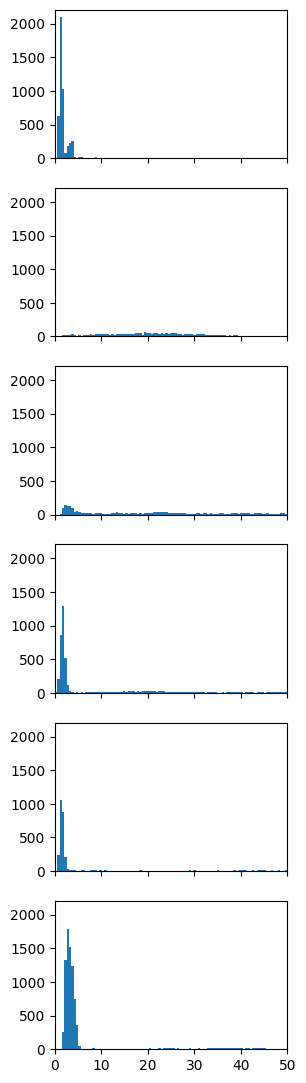

In [38]:
fig, axs = plt.subplots(6, 1, figsize=(3, 4.5*3), sharex=True, sharey=True)

for i in range(len(axs)):
    ax = axs[i]
    idx = idx_list[i]
    gal = gal_list[i]
    com = centering['com0'][idx]
    
    logFeH0 = 0
    dlogFeH = 0.1
    
    FeH = gal.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)
    
    r0 = np.linalg.norm(gal.sn.part0.pos.value - com, axis=1)
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    ax.hist(r0[key], bins=np.linspace(0, 50, 100))
        
ax.set(xlim=(0, 50), ylim=(0, None))

In [39]:
pos = np.random.rand(100, 3)
r = np.linalg.norm(pos, axis=1)
rhat = pos/r.reshape(-1, 1)
vel = np.random.rand(100, 3)
vel_r = (rhat*vel).sum(axis=1)

In [59]:
def get_diff_sfr(sim, idx, com, comv, rcut=2, logFeH0=0., dlogFeH=0.1, rflow=20, drflow=5):
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs'+str(sim[0])+'-Vv'+str(sim[1])+'-e'+\
                 str(sim[2])+'/output/'
    fname = output_dir+'snapshot_'+str(idx).zfill(3)+'.hdf5'
    
    # read in stuff
    file = h5.File(fname, mode='r')
    
    time = file['Header'].attrs['Time']
    
    pos0 = file['PartType0/Coordinates'][:]
    vel0 = file['PartType0/Velocities'][:]
    sfr0 = file['PartType0/StarFormationRate'][:]
    mass0 = file['PartType0/Masses'][:]
    
    FeH = file['PartType0/GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = file['PartType0/GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    massFe = mass0 * FeH * GFM_SOLAR_ABUNDANCE_IRON
    massMg = mass0 * MgH * GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgFe = np.log10(MgH/FeH)
    
    file.close()
    
    # compute relevant sfr
    globsfr = np.sum(sfr0)
    r0      = np.linalg.norm(pos0 - com, axis=1)
    logFeH  = np.log10(FeH)
    
    in_Fe    = np.logical_and(logFeH > logFeH0-dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    in_rcut  = r0 < rcut
    out_rcut = np.logical_not(in_rcut)
    
    sfr_inrcut  = np.sum(sfr0[in_rcut])
    sfr_outrcut = np.sum(sfr0[out_rcut])
    
    sfr_inrcut_Fe  = np.sum(sfr0[np.logical_and(in_rcut,  in_Fe)])
    sfr_outrcut_Fe = np.sum(sfr0[np.logical_and(out_rcut, in_Fe)])
    
    mass_inFe = np.sum(mass0[in_Fe])

    # compute inflow and outflow rate
    in_shell   = np.logical_and(r0 > rflow - drflow/2., r0 < rflow + drflow/2.)
    rhat       = pos0/r0.reshape(-1,1)
    vel_r      = (rhat*(vel0-comv)).sum(axis=1)
    
    is_inflow  = np.logical_and(vel_r < 0, in_shell)
    is_outflow = np.logical_and(vel_r > 0, in_shell)
    
    Mdot_in    = np.sum(mass0[is_inflow]*vel_r[is_inflow])/drflow
    Mdot_out   = np.sum(mass0[is_outflow]*vel_r[is_outflow])/drflow
    
    MFedot_in  = np.sum(massFe[is_inflow]*vel_r[is_inflow])/drflow
    MFedot_out = np.sum(massFe[is_outflow]*vel_r[is_outflow])/drflow
    
    # compute 2D mass hist
    in_gal = r0 < 12
    dt = 0.025
    bins = [np.arange(-1., 0.5+0.01, 0.01), np.arange(0.1, 0.7+0.01, 0.01)]
    Mgas_map, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_gal], logMgFe[in_gal], mass0[in_gal]*dt, statistic='sum')
    
    # construct output
    out = {}
    out['time']           = time
    out['globsfr']        = globsfr
    out['sfr_inrcut']     = sfr_inrcut
    out['sfr_outrcut']    = sfr_outrcut
    out['sfr_inrcut_Fe']  = sfr_inrcut_Fe
    out['sfr_outrcut_Fe'] = sfr_outrcut_Fe
    out['mass_inFe']      = mass_inFe
    out['Mdot_in']        = Mdot_in
    out['Mdot_out']       = Mdot_out
    out['MFedot_in']      = MFedot_in
    out['MFedot_out']     = MFedot_out
    out['Mgas_map']       = Mgas_map
    out['Mgas_map_xedge'] = x_edge
    out['Mgas_map_yedge'] = y_edge
    
    return out

In [62]:
[np.arange(-1., 0.5+0.01, 0.01), np.arange(0.1, 0.7+0.01, 0.01)]

[array([-1.0000000e+00, -9.9000000e-01, -9.8000000e-01, -9.7000000e-01,
        -9.6000000e-01, -9.5000000e-01, -9.4000000e-01, -9.3000000e-01,
        -9.2000000e-01, -9.1000000e-01, -9.0000000e-01, -8.9000000e-01,
        -8.8000000e-01, -8.7000000e-01, -8.6000000e-01, -8.5000000e-01,
        -8.4000000e-01, -8.3000000e-01, -8.2000000e-01, -8.1000000e-01,
        -8.0000000e-01, -7.9000000e-01, -7.8000000e-01, -7.7000000e-01,
        -7.6000000e-01, -7.5000000e-01, -7.4000000e-01, -7.3000000e-01,
        -7.2000000e-01, -7.1000000e-01, -7.0000000e-01, -6.9000000e-01,
        -6.8000000e-01, -6.7000000e-01, -6.6000000e-01, -6.5000000e-01,
        -6.4000000e-01, -6.3000000e-01, -6.2000000e-01, -6.1000000e-01,
        -6.0000000e-01, -5.9000000e-01, -5.8000000e-01, -5.7000000e-01,
        -5.6000000e-01, -5.5000000e-01, -5.4000000e-01, -5.3000000e-01,
        -5.2000000e-01, -5.1000000e-01, -5.0000000e-01, -4.9000000e-01,
        -4.8000000e-01, -4.7000000e-01, -4.6000000e-01, -4.50000

In [60]:
def get_sfr_dat(sim, rcut=2.5, use_tqdm=True, no_parallel=False):
    idx_list = np.arange(320+1)
    
    centering = np.load('../bim_metric/centering/sim_'+str(sim[0])+'_'+str(sim[1])+'_'+str(sim[2])+'.npy',
                    allow_pickle=True).item()
    
    if use_tqdm:
        itr = zip(tqdm(idx_list, leave=True, position=0), centering['com0'], centering['comv0'])
    else:
        itr = zip(idx_list, centering['com0'], centering['comv0'])
    
    if no_parallel:
        outs = [get_diff_sfr(sim, idx, com, comv, rcut=rcut) for idx,com,comv in itr]
    else:
        outs = Parallel(n_jobs=24)(delayed(get_diff_sfr)(sim, idx, com, comv, rcut=rcut) 
                        for idx,com,comv in itr)
    
    
    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            if k in out.keys():
                dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])
        
    return dat

In [61]:
get_sfr_dat(('142', '116', '05'), use_tqdm=True, no_parallel=True)

  2%|▏         | 5/321 [00:04<04:56,  1.06it/s]

ValueError: The smallest edge difference is numerically 0.

In [43]:
# Rs_values = ['116', '129', '142']
Rs_values = ['142']
Vv_values = ['116', '129', '142']
ecc_values = ['04', '05', '06']

# Generate all combinations manually
simulations = [(Rs, Vv, ecc) for Rs in Rs_values for Vv in Vv_values for ecc in ecc_values]

sfrdats = {}
for Rs in Rs_values:
    sfrdats[Rs] = {}
    for Vv in Vv_values:
        sfrdats[Rs][Vv] = {}

for sim in tqdm(simulations, leave=True, position=0):
    Rs, Vv, ecc = sim
    if Rs != '142':
        continue
    sfrdats[Rs][Vv][ecc] = get_sfr_dat(sim, use_tqdm=False, rcut=3)


100%|██████████| 9/9 [02:14<00:00, 15.00s/it]


In [44]:
sfrdats['142']['116']['05'].keys()

dict_keys(['time', 'globsfr', 'sfr_inrcut', 'sfr_outrcut', 'sfr_inrcut_Fe', 'sfr_outrcut_Fe', 'mass_inFe', 'Mdot_in', 'Mdot_out', 'MFedot_in', 'MFedot_out'])

(0.0, 39.28715286254883)

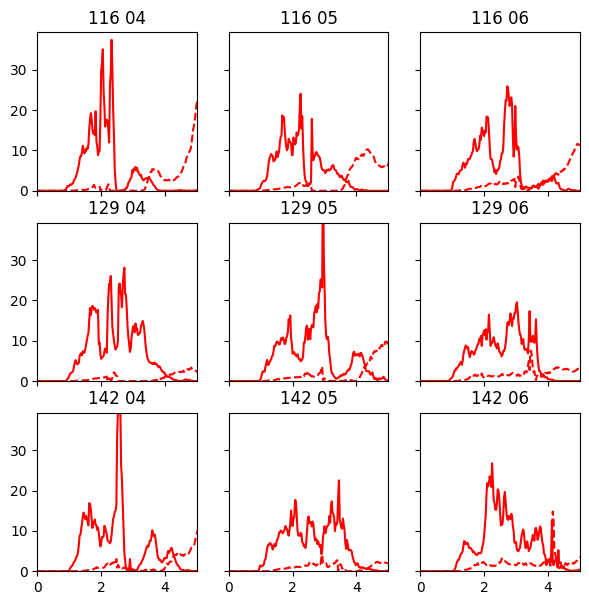

In [45]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

i = 0
for Vv in Vv_values:
    for ecc in ecc_values:
        ax = axs.ravel()[i]
        
        dat = sfrdats['142'][Vv][ecc]
        ax.plot(dat['time'], dat['sfr_inrcut_Fe']/0.05, c='r')
        ax.plot(dat['time'], dat['sfr_outrcut_Fe']/0.05, c='r', ls='dashed')
        ax.set_title(Vv+' '+ecc)
        ax.set(xlim=(0, 5), ylim=(0, None))
        i += 1

# plt.plot(dat['time'], dat['sfr_inrcut'], c='b')
# plt.plot(dat['time'], dat['sfr_outrcut'], c='b', ls='dashed')
# 
# plt.plot(dat['time'], dat['sfr_inrcut_Fe']/0.05, c='r')
# plt.plot(dat['time'], dat['sfr_outrcut_Fe']/0.05, c='r', ls='dashed')

plt.ylim(0, None)

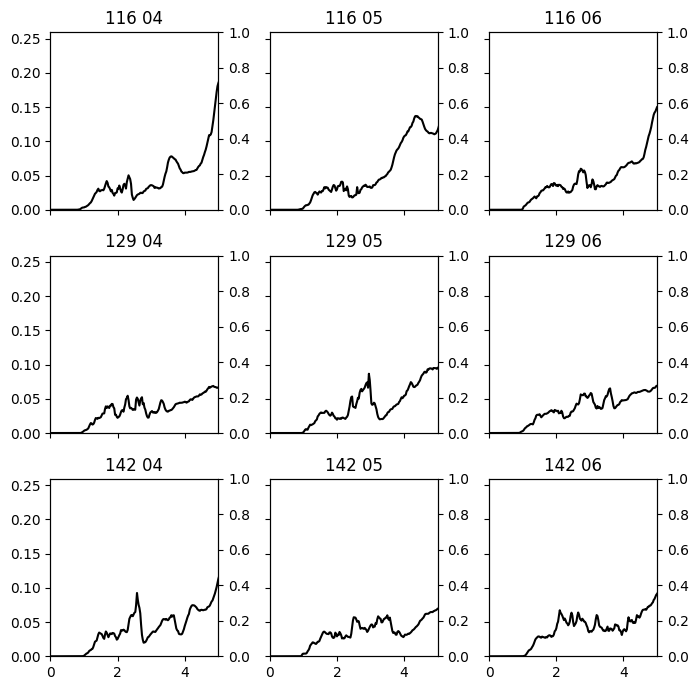

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

i = 0
for Vv in Vv_values:
    for ecc in ecc_values:
        ax = axs.ravel()[i]
        
        dat = sfrdats['142'][Vv][ecc]
        ax.plot(dat['time'], dat['mass_inFe'], c='k')
        ax.set_title(Vv+' '+ecc)
        ax.set(xlim=(0, 5), ylim=(0, None))
        
        ax2 = ax.twinx()
        # ax2.plot(dat['time'], dat['MFedot_out'], c='b')
        # ax2.plot(dat['time'], -dat['MFedot_in'], c='b', ls='dashed')
        ax2.set_ylim(0, None)
        
        # ax2.plot(dat['time'], dat['MFedot_out'] + dat['MFedot_in'], c='b')
        # ax2.set_ylim(-0.01, 0.01)
        
        i += 1

# plt.plot(dat['time'], dat['sfr_inrcut'], c='b')
# plt.plot(dat['time'], dat['sfr_outrcut'], c='b', ls='dashed')
# 
# plt.plot(dat['time'], dat['sfr_inrcut_Fe']/0.05, c='r')
# plt.plot(dat['time'], dat['sfr_outrcut_Fe']/0.05, c='r', ls='dashed')

# plt.ylim(0, None)
fig.tight_layout()

In [50]:
dat.keys()

dict_keys(['time', 'globsfr', 'sfr_inrcut', 'sfr_outrcut', 'sfr_inrcut_Fe', 'sfr_outrcut_Fe', 'mass_inFe', 'Mdot_in', 'Mdot_out', 'MFedot_in', 'MFedot_out'])

/tmp/ipykernel_1050543/3133350752.py:14: RuntimeWarning: divide by zero encountered in divide
  ax.plot(dat['time'], dat['globsfr']/dat['mass_inFe']/10, c='k')
/tmp/ipykernel_1050543/3133350752.py:14: RuntimeWarning: invalid value encountered in divide
  ax.plot(dat['time'], dat['globsfr']/dat['mass_inFe']/10, c='k')


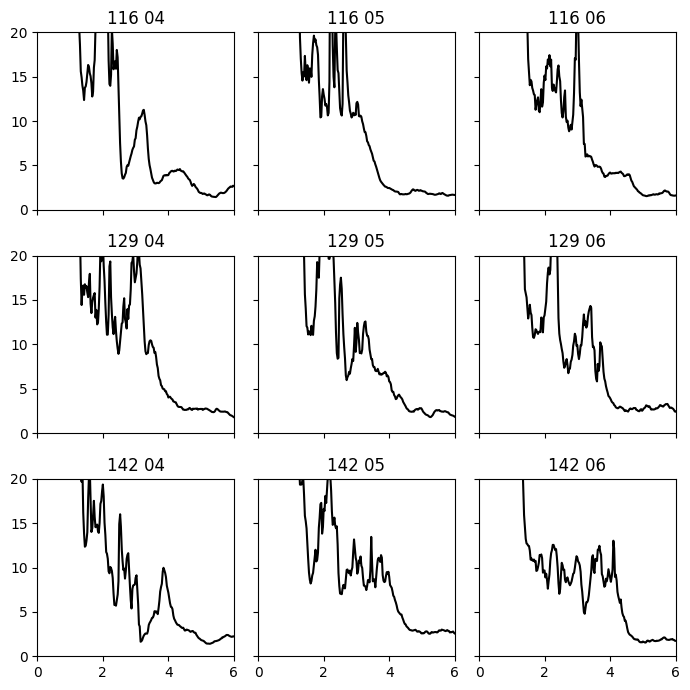

In [55]:
# depletion time

fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

i = 0
for Vv in Vv_values:
    for ecc in ecc_values:
        
        ax = axs.ravel()[i]
        
        dat = sfrdats['142'][Vv][ecc]
        sfr_Fe = dat['sfr_inrcut_Fe']+dat['sfr_outrcut_Fe']
        # ax.plot(dat['time'], sfr_Fe/dat['mass_inFe']/10, c='k')
        ax.plot(dat['time'], dat['globsfr']/dat['mass_inFe']/10, c='k')
        ax.set_title(Vv+' '+ecc)
        ax.set(xlim=(0, 6), ylim=(0, 20))
        
        # ax2 = ax.twinx()
        # ax2.plot(dat['time'], dat['MFedot_out'], c='b')
        # ax2.plot(dat['time'], -dat['MFedot_in'], c='b', ls='dashed')
        # ax2.plot(dat['time'], dat['MFedot_out'] + dat['MFedot_in'], c='b')
        # ax2.set_ylim(-0.05, 0.05)
        
        i += 1

fig.tight_layout()

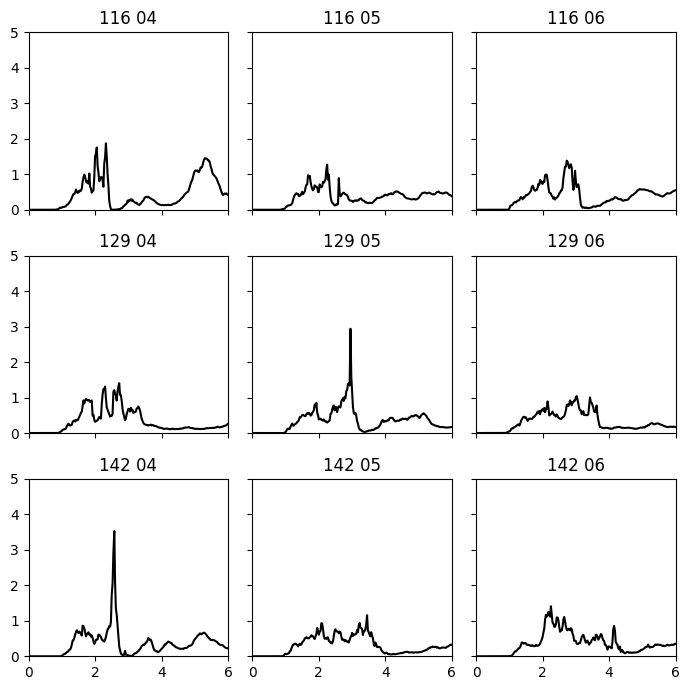

In [57]:
# depletion time

fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

i = 0
for Vv in Vv_values:
    for ecc in ecc_values:
        
        ax = axs.ravel()[i]
        
        dat = sfrdats['142'][Vv][ecc]
        sfr_Fe = dat['sfr_inrcut_Fe']+dat['sfr_outrcut_Fe']
        ax.plot(dat['time'], sfr_Fe, c='k')
        # ax.plot(dat['time'], dat['globsfr']/dat['mass_inFe']/10, c='k')
        ax.set_title(Vv+' '+ecc)
        ax.set(xlim=(0, 6), ylim=(0, 5))
        
        # ax2 = ax.twinx()
        # ax2.plot(dat['time'], dat['MFedot_out'], c='b')
        # ax2.plot(dat['time'], -dat['MFedot_in'], c='b', ls='dashed')
        # ax2.plot(dat['time'], dat['MFedot_out'] + dat['MFedot_in'], c='b')
        # ax2.set_ylim(-0.05, 0.05)
        
        i += 1

fig.tight_layout()